In [78]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

plt.rc('font',size=18)
plt.rcParams['figure.constrained_layout.use'] = True 
plt.rcParams.update({'font.size':22})
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7
#%matplotlib inline


In [5]:
pearse =pd.read_csv("pearseProcessed.csv",usecols=[0,1,3],parse_dates=[0])
portobello = pd.read_csv("portobelloProcessed.csv",usecols=[0,1,3],parse_dates=[0])

In [6]:
def convertDays(df):
    convertSec = 1000000000
    # tFull = pd.array(pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec
    tFull = ((pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec).values
    dt = tFull[1] -tFull[0]
    print(dt)

    t = (tFull-tFull[0]) /60 /60/24
    #df.iloc[:,4]=t.tolist()
    return t ,dt  

In [7]:
secondsPearse,dt = convertDays(pearse)
pearse['days']=secondsPearse.tolist()
portobello['days']= secondsPearse.tolist()

300.0


C:\Users\brosn\AppData\Local\Temp/ipykernel_32264/231375872.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tFull = ((pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec).values


In [8]:
def BuildModel(q,y,t):
    lag=3
    stride=1
  
    w=math.floor(7*24*60*60/dt) # number of samples per week
    len =y.size-w-lag*w-q
    XX=y[q:q+len:stride]
    for i in range(1,lag):
        X=y[i*w+q:i*w+q+len:stride]
        XX=np.column_stack((XX,X))

    d=math.floor(24*60*60/dt) # number of samples per day

    for i in range(0,lag):
        X=y[i*d+q:i*d+q+len:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=y[i:i+len:stride]
        XX=np.column_stack((XX,X))

    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]

    yy.reset_index(drop=True, inplace=True)
    tt.reset_index(drop=True, inplace=True)
    return tt,yy,XX

In [133]:
qVal=[2,6,12]
stride = 1
lag = 3
#y =result.iloc[:,1]
y= portobello.iloc[:,1]
t=portobello.iloc[:,3]
alphaRange = [.00001, 0.0001,0.001, 0.01,1]

In [97]:

tt,yy,XX = BuildModel(2,y,t)
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)
MSE =[]; meanE=[];stdE=[]
cv = TimeSeriesSplit(n_splits=5)
for a in alphaRange:
    for train,test in cv.split(XX):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX[train],yy[train])
        yPred = model.predict(XX[test])
        yp2 =np.rint(yPred)
        MSE.append(mean_squared_error(yp2,yy[test]))
        #print(np.sqrt(MSE))
    meanE.append(np.array(np.sqrt(MSE)).mean())
    #print(meanE)
    stdE.append(np.array(np.sqrt(MSE)).std())


In [98]:
def crossEvalAlpha(q,y,t):
    tt,yy,XX = BuildModel(q,y,t)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)
    MSE =[]; meanE=[];stdE=[]
    temp =[]; meanETrain =[]; stdETrain=[]
    cv = TimeSeriesSplit(n_splits=5)
    for a in alphaRange:
        for train,test in cv.split(XX):
            model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX[train],yy[train])
            yPred = model.predict(XX[test])
            yPredTrain = model.predict(XX[train])
            yp2 =np.rint(yPred)
            MSE.append(mean_squared_error(yp2,yy[test]))
            temp.append(mean_squared_error(yPredTrain,yy[train]))
            #print(np.sqrt(MSE))
        meanE.append(np.array(np.sqrt(MSE)).mean())
        meanETrain.append(np.array(np.sqrt(temp)).mean())
        #print(meanE)
        stdE.append(np.array(np.sqrt(MSE)).std())
        stdETrain.append(np.array(np.sqrt(temp)).std())
    return meanE,stdE,meanETrain,stdETrain


In [115]:
def printCrossEval(m10,std10,m30,std30,mean1,std1,m0,s0,m1,s1,m2,s2,alpha,TITLE):
    plt.title(TITLE,size=35)
    plt.rcParams['figure.figsize']=[9,7]
    plt.xlabel("C",size=20)
    plt.ylabel(" MSE ",size=20)
    plt.errorbar(alpha,m10,yerr=std10,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m30,yerr=std30,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,mean1,yerr=std1,fmt="-o",ecolor="g",capsize=10)
    ## plot training results 
    plt.errorbar(alpha,m0,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m1,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,m2,fmt="-o",ecolor="g",capsize=10)
    plt.xscale('log')
    plt.legend(["10m test predictions","30m test predictions","1h test predictions","10m train predictions","30m train predictions","1h train predictions "],loc='lower right',fontsize=15)
    plt.rcParams['figure.figsize']=[12,6]

In [145]:
def gridridge(q,y,t):
  tt,yy,XX = BuildModel(q,y,t)
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)

  model = Ridge()
  cv =TimeSeriesSplit(n_splits=5)
  param = {
      'alpha':[.00001, 0.0001,0.001, 0.01,1], #np.arange(0, 1.001, 0.01)
      'fit_intercept':[True,False],
      'normalize':[True,False],
  'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        }

  search = GridSearchCV(Ridge(), param, scoring='r2', n_jobs=-1, cv=cv)
  result = search.fit(XX[train], yy[train])
  print('Best Model: \n')
  best=result.best_params_

  model=Ridge(**result.best_params_).fit(XX[train], yy[train])
  yTrain = yy[train]
  yTest = yy[test]
  yTemp = np.rint(model.predict(XX[train]))
  yPred = np.rint(model.predict(XX[test]))

  #metrics  
  mse_tr=metrics.mean_squared_error(yTrain, yTemp)
  mse_te=metrics.mean_squared_error(yTest, yPred)
  r2_tr=metrics.r2_score(yTrain, yTemp)
  r2_te=metrics.r2_score(yTest, yPred)

  print('Training set mse: ',mse_tr )
  print('Test set mse: ', mse_te)
  print('Training set r2: ', r2_tr)
  print('Test set r2: ', r2_te)
  print(model.intercept_, model.coef_)

  return mse_tr,mse_te,r2_tr,r2_te, best,tt,yTrain,yTest,yTemp,yPred

[6.655356133733941, 6.717038042985491, 6.76057126650605, 6.783707434095317, 6.797415763601964]
----------------------------------------


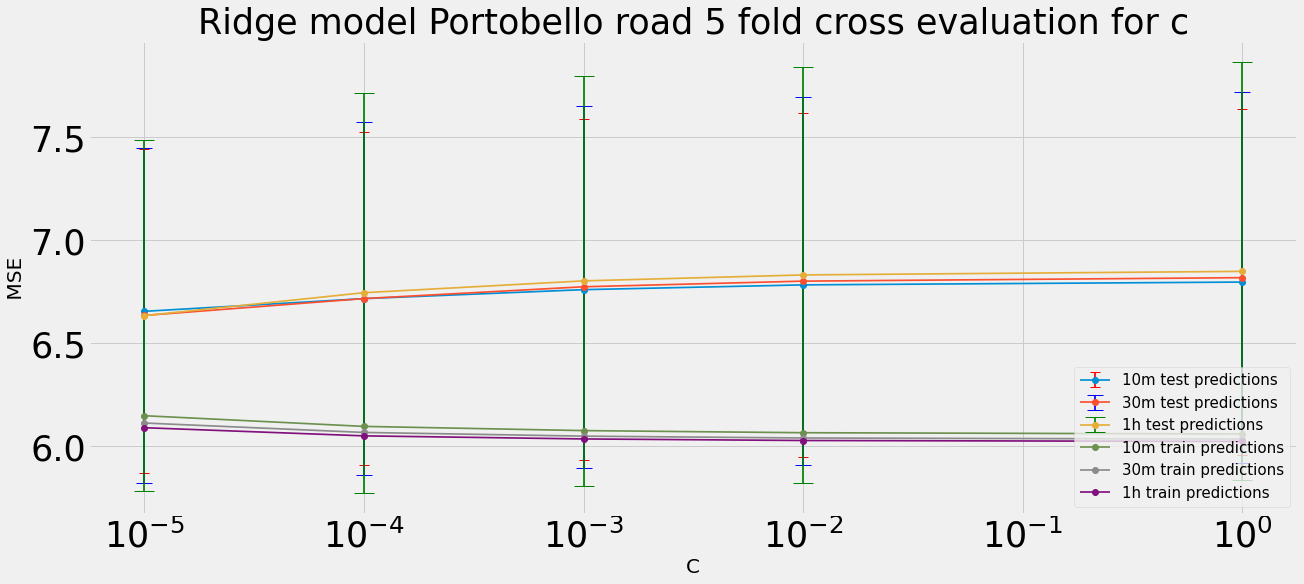

In [134]:
meanE0,stdE0,m0,s0 = crossEvalAlpha(qVal[0],y,t)
meanE1,stdE1,m1,s1 = crossEvalAlpha(qVal[1],y,t)
meanE2,stdE2,m2,s2 = crossEvalAlpha(qVal[2],y,t)
print(meanE0)
print("----------------------------------------")
title = "Ridge model Portobello road 5 fold cross evaluation for c"
printCrossEval(meanE0,stdE0,meanE1,stdE1,meanE2,stdE2,m0,s0,m1,s1,m2,s2,alphaRange,title)


Between the three models the prefor,ance does not vary greatly however the error fort the prediction in 1 houe is the highest as expected for predictions in a hour
lowest c value results in a highest error THIS increases the penalty applied 


there is quite a devisation between the mean squared error on the training and testing data. As the error for the trainingdata drops the error on the testing data increases this indicates overfitting to the training data. Methods to improve this are regularisatioin which is implemented here- what is noted is the lowest value for the testing predictions is the largest error for the training predictions. This value for c=0.00001 also provides the smallest standard deviation. However it is evident that there is overfitting.-- similiar to what is seen 

[2, 6, 12]

In [146]:
mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1,best_q1,tt1,y_train,y_test,y_hat_q1,y_pred_q1=gridridge(qVal[0],y,t)
mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2,best_q2,tt2,y_train,y_test,y_hat_q2,y_pred_q2=gridridge(qVal[1],y,t)
mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3,best_q3,tt3,y_train,y_test,y_hat_q3,y_pred_q3=gridridge(qVal[2],y,t)

C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

Best Model: 

Training set mse:  41.51592356687898
Test set mse:  32.489583333333336
Training set r2:  0.3471988271531955
Test set r2:  0.44732232455490006
4.486014266393791 [0.05077351 0.11886668 0.11371863 0.05077351 0.0861776  0.04714392
 0.05437815 0.05180407 0.05077351]


C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

Best Model: 

Training set mse:  41.33091857432628
Test set mse:  32.15411355735805
Training set r2:  0.34929278077967263
Test set r2:  0.4532727309255836
4.458704001165888 [0.05671611 0.11860151 0.11337594 0.05671611 0.08463173 0.04649178
 0.05126224 0.04997414 0.05042355]
Best Model: 

Training set mse:  41.24463145676146
Test set mse:  32.082366589327144
Training set r2:  0.34946081218996394
Test set r2:  0.4547353268417589
4.423264643843376 [0.06625725 0.12082614 0.11616029 0.06625725 0.08391457 0.04596272
 0.04430466 0.04395719 0.04574464]


C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

In [136]:
q1_df=pd.DataFrame.from_dict(best_q1, orient='index',columns=['q=2'])
q2_df=pd.DataFrame.from_dict(best_q2, orient='index',columns=['q=6'])
q3_df=pd.DataFrame.from_dict(best_q3, orient='index',columns=['q=12'])
df_best_rd=pd.concat([q1_df,q2_df,q3_df],axis=1)

m1_q1=pd.DataFrame(data=[mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=2'])
m2_q2=pd.DataFrame(data=[mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=6'])
m3_q3=pd.DataFrame(data=[mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=12'])
df_metrics_rd=pd.concat([m1_q1,m2_q2,m3_q3],axis=1)

df_params=pd.concat([df_best_rd,df_metrics_rd],axis=0)

In [137]:
df_params

,q=2,q=6,q=12
alpha,1,1,1
fit_intercept,True,True,True
normalize,True,True,True
solver,sparse_cg,saga,lsqr
mse_train,41.515924,41.330919,41.244631
mse_test,32.489583,32.174971,32.082367
r2_train,0.347199,0.349293,0.349461
r2_test,0.447322,0.452918,0.454735


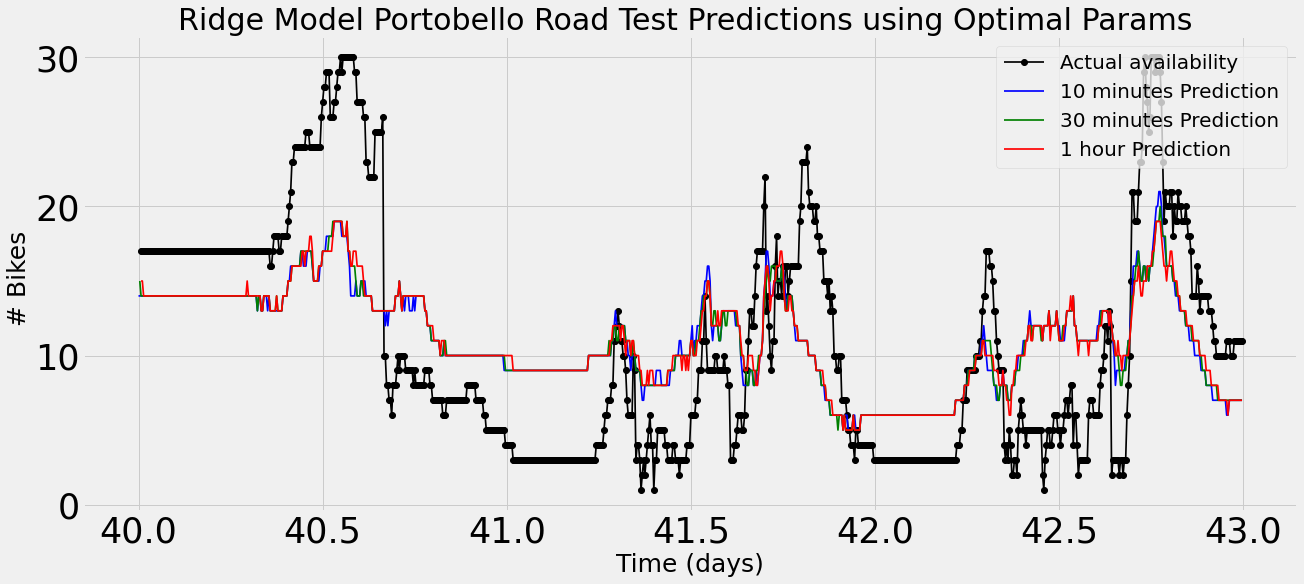

In [132]:
plt.plot(tt[-len(y_test):],y_test,'-o',color='black')
plt.plot(tt1[-len(y_pred_q1):],y_pred_q1,color='blue')
plt.plot(tt2[-len(y_pred_q2):],y_pred_q2,color='green')
plt.plot(tt3[-len(y_pred_q3):],y_pred_q3,color='red')
plt.title("Ridge Model Portobello Road Test Predictions using Optimal Params ",size=30)
plt.legend(["Actual availability","10 minutes Prediction","30 minutes Prediction","1 hour Prediction"],loc='upper right',fontsize=20)

#plt.xlim((4*7+4,4*8))
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.rcParams['figure.figsize']=[18,8]

In [139]:
t.size

12384

0.0 [0.05452933 0.2541136  0.15870398 0.05452933 0.16204217 0.10885334
 0.07286718 0.05797766 0.05452933]
0.0 [0.06939388 0.25090508 0.15735744 0.06939388 0.15627518 0.10837895
 0.06729422 0.0527293  0.04823415]
0.0 [0.08231148 0.24790898 0.16004971 0.08231148 0.14956913 0.10705398
 0.0637683  0.04726407 0.04427494]
The mse for y=2 ,6,12 respectively is : 6.279631010834724 6.265694249808363 6.2367408101625985


C:\Users\brosn\AppData\Local\Temp/ipykernel_32264/4133525309.py:52: UserWarning: Attempting to set identical left == right == 32 results in singular transformations; automatically expanding.
  plt.xlim((4*7+4,4*8))


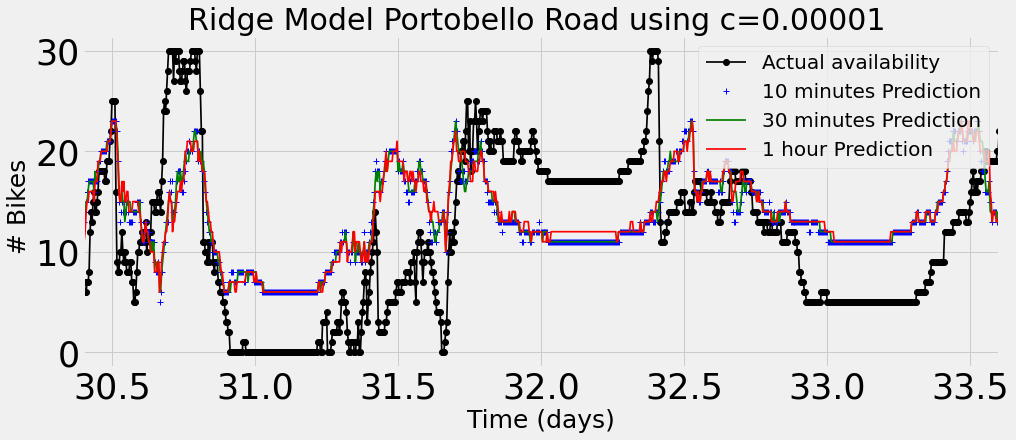

In [61]:
## now train the model using kfolds 
a = 0.00001
## just plot test data
q=2
tt,yy,XX = BuildModel(q,y,t)
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)
cv = TimeSeriesSplit(n_splits=5)
for train,test in cv.split(XX):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX[train],yy[train])
print(model.intercept_,model.coef_)

yPred=model.predict(XX)     
yPred=np.rint(yPred)
mse = mean_squared_error(yPred,yy)

q=6
tt1,yy1,XX1 = BuildModel(q,y,t)
train, test = train_test_split(np.arange(0,yy1.size),test_size=0.2,shuffle=False)

cv = TimeSeriesSplit(n_splits=5)
for train,test in cv.split(XX1):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX1[train],yy1[train])
print(model.intercept_,model.coef_)

yPred1=model.predict(XX1)     
yPred1	=np.rint(yPred1)
mse1 = mean_squared_error(yPred1,yy1)

q=12
tt2,yy2,XX2 = BuildModel(q,y,t)
train, test = train_test_split(np.arange(0,yy2.size),test_size=0.2,shuffle=False)

cv = TimeSeriesSplit(n_splits=5)
for train,test in cv.split(XX2):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX2[train],yy2[train])

print(model.intercept_,model.coef_)

yPred2=model.predict(XX2)     
yp2 =np.rint(yPred2)
MSE2=mean_squared_error(yp2,yy2)


print("The mse for y=2 ,6,12 respectively is :",math.sqrt(mse),math.sqrt(mse1),math.sqrt(MSE2))

plt.plot(t,y,'-o',color='black')
plt.plot(tt,yPred,"+",color='blue')
plt.plot(tt1,yPred1,color='green')
plt.plot(tt2,yp2,color='red')
plt.title("Ridge Model Portobello Road using c=0.00001 ",size=30)
plt.legend(["Actual availability","10 minutes Prediction","30 minutes Prediction","1 hour Prediction"],loc='upper right',fontsize=20)
plt.xlim((4*7+4,4*8))
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.rcParams['figure.figsize']=[14,6]

fO PEARSE STREET STATION AND DO THE BASELINE MODEL 

In [69]:
qVal = [2,6,12]


In [73]:
## bASELIN MODEL 
for i in qVal:
    tt,yy,XX = BuildModel(i,y,t)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)
    MSE =[]; meanE=[];stdE=[]
    dummyReg = DummyRegressor(strategy="mean")
    cv = TimeSeriesSplit(n_splits=5)
    for train,test in cv.split(XX):
        dummyReg.fit(XX[train],yy[train])
        yPred =dummyReg.predict(XX)
        MSE.append(mean_squared_error(yPred,yy))
    meanE.append(np.array(np.sqrt(MSE)).mean())
    print("q",i,"Mean squared error",meanE)







q 2 Mean squared error [7.9896137358355075]
q 6 Mean squared error [7.983501416941428]
q 12 Mean squared error [7.974499830155506]


In [68]:

bikes = pearse.iloc[:,1]
time = pearse.iloc[:,3]

In [14]:
pearse

,TIME,AVAILABLE BIKES,dataType,days
0,2020-01-28 00:00:02,30,wday,0.000000
1,2020-01-28 00:05:02,30,wday,0.003472
2,2020-01-28 00:10:02,30,wday,0.006944
3,2020-01-28 00:15:02,30,wday,0.010417
4,2020-01-28 00:20:02,30,wday,0.013889
...,...,...,...,...
12379,2020-03-10 23:35:02,29,wday,42.982639
12380,2020-03-10 23:40:02,28,wday,42.986111
12381,2020-03-10 23:45:02,28,wday,42.989583
12382,2020-03-10 23:50:02,28,wday,42.993056


In [ ]:
### REDO ALL FOR PEARSE NO COMMENTS SAVED 

----------------------------------------


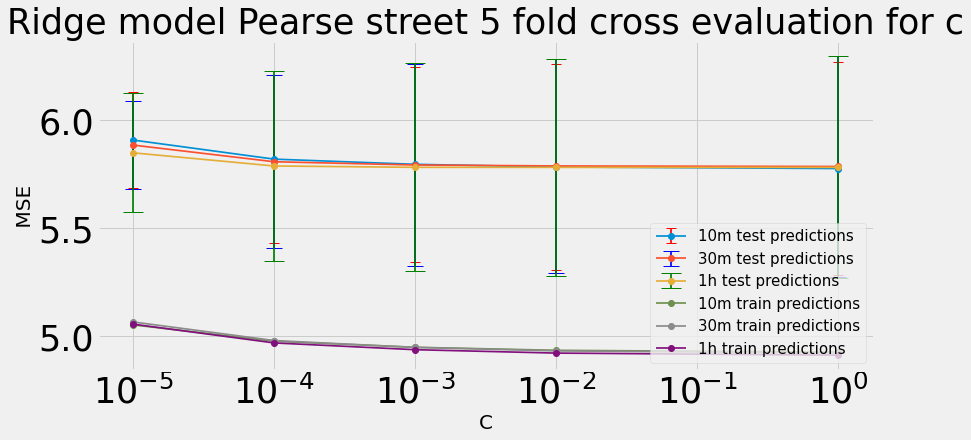

In [117]:
meanE0,stdE0,m0,s0 = crossEvalAlpha(qVal[0],bikes,t)
meanE1,stdE1,m1,s1 = crossEvalAlpha(qVal[1],bikes,t)
meanE2,stdE2,m2,s2 = crossEvalAlpha(qVal[2],bikes,t)

print("----------------------------------------")
title = "Ridge model Pearse street 5 fold cross evaluation for c"
printCrossEval(meanE0,stdE0,meanE1,stdE1,meanE2,stdE2,m0,s0,m1,s1,m2,s2,alphaRange,title)

In [147]:
mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1,best_q1,tt1,y_train,y_test,y_hat_q1,y_pred_q1=gridridge(qVal[0],bikes,time)
mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2,best_q2,tt2,y_train,y_test,y_hat_q2,y_pred_q2=gridridge(qVal[1],bikes,time)
mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3,best_q3,tt3,y_train,y_test,y_hat_q3,y_pred_q3=gridridge(qVal[2],bikes,time)

C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Best Model: 

Training set mse:  25.61783439490446
Test set mse:  37.6400462962963
Training set r2:  0.7576436484172582
Test set r2:  0.49119771856094985
0.0 [ 0.04683014  0.39091117  0.325358    0.04683014  0.24282895 -0.11530331
 -0.08683892  0.03099929  0.04683014]


C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

Best Model: 

Training set mse:  25.558968414952187
Test set mse:  38.21900347624565
Training set r2:  0.7583416700502104
Test set r2:  0.4839694077743577
0.0 [ 0.06771758  0.39697968  0.33471589  0.06771758  0.23319515 -0.10861838
 -0.03014446 -0.02311693 -0.00836844]
Best Model: 

Training set mse:  25.44573418456181
Test set mse:  38.86658932714617
Training set r2:  0.7596574862800902
Test set r2:  0.4758336614864932
0.0 [ 0.07577754  0.40414456  0.31543232  0.07577754  0.25175598 -0.10933811
 -0.07801784 -0.04086587  0.03559167]


C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\brosn\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [120]:
q1_df=pd.DataFrame.from_dict(best_q1, orient='index',columns=['q=2'])
q2_df=pd.DataFrame.from_dict(best_q2, orient='index',columns=['q=6'])
q3_df=pd.DataFrame.from_dict(best_q3, orient='index',columns=['q=12'])
df_best_rd=pd.concat([q1_df,q2_df,q3_df],axis=1)

m1_q1=pd.DataFrame(data=[mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=2'])
m2_q2=pd.DataFrame(data=[mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=6'])
m3_q3=pd.DataFrame(data=[mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=12'])
df_metrics_rd=pd.concat([m1_q1,m2_q2,m3_q3],axis=1)

df_params=pd.concat([df_best_rd,df_metrics_rd],axis=0)

In [85]:
df_params

,q=2,q=6,q=12
alpha,0.0001,1,1
fit_intercept,False,False,False
normalize,False,True,False
solver,sag,sparse_cg,sag
mse_train,25.546962,25.50829,25.357688
mse_test,37.730066,38.47111,38.851256
r2_train,0.758314,0.758821,0.760489
r2_test,0.489981,0.480565,0.47604


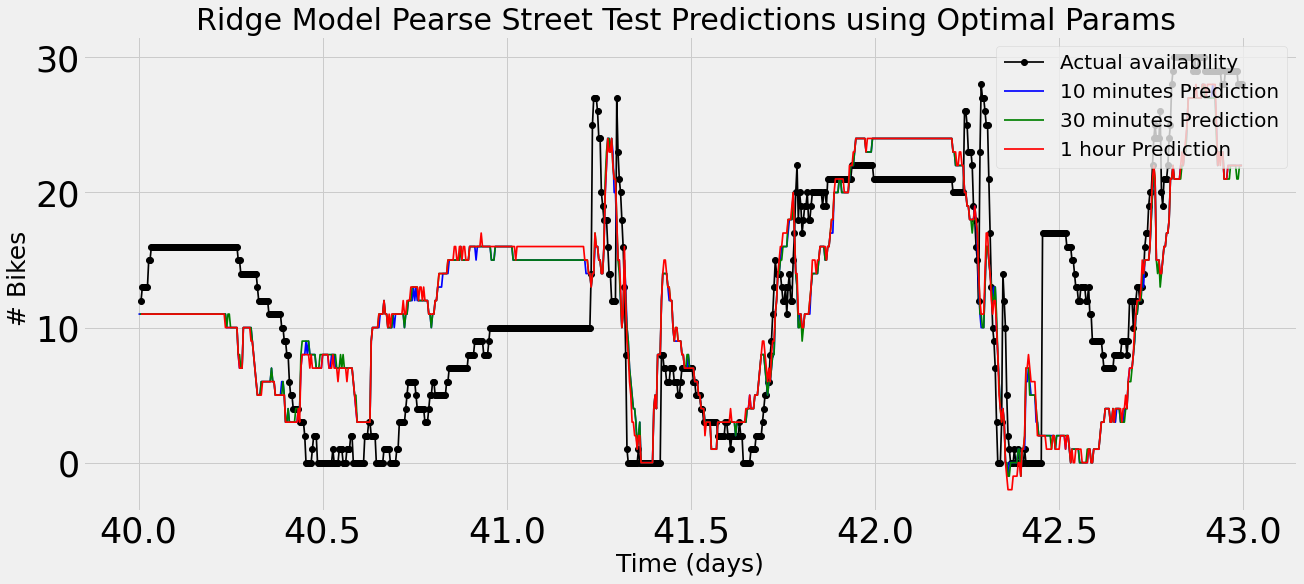

In [124]:
plt.plot(tt[-len(y_test):],y_test,'-o',color='black')
plt.plot(tt1[-len(y_pred_q1):],y_pred_q1,color='blue')
plt.plot(tt2[-len(y_pred_q2):],y_pred_q2,color='green')
plt.plot(tt3[-len(y_pred_q3):],y_pred_q3,color='red')
plt.title("Ridge Model Pearse Street Test Predictions using Optimal Params ",size=30)
plt.legend(["Actual availability","10 minutes Prediction","30 minutes Prediction","1 hour Prediction"],loc='upper right',fontsize=20)

#plt.xlim((4*7+4,4*8))
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.rcParams['figure.figsize']=[18,8]

Again as seen for model with portobello road overfitting is evident as the training data preofrms better than the testing data. 
When c = 0.0001 this is when the lowest mse is obtained any further increase does not result in notable change in the mse but the std increases. A method to overcome this would be to try further regulaarization techniques -fit a polynomial or include more data to better train the model.

0.0 [ 0.04451855  0.36468734  0.33259338  0.04451855  0.2333105  -0.09701864
 -0.04203373  0.01027698  0.04451855]
0.0 [ 0.07731406  0.36937151  0.3307348   0.07731406  0.23587332 -0.09483006
 -0.03412782 -0.02282516 -0.00270446]
0.0 [ 0.07977885  0.37704936  0.32421607  0.07977885  0.24112812 -0.09063829
 -0.05770693 -0.02872745  0.01198131]
The mse for y=2 ,6,12 respectively is : 5.288022068500001 5.294436859545363 5.2990863072548935


C:\Users\brosn\AppData\Local\Temp/ipykernel_32264/2089706067.py:52: UserWarning: Attempting to set identical left == right == 32 results in singular transformations; automatically expanding.
  plt.xlim((4*7+4,4*8))


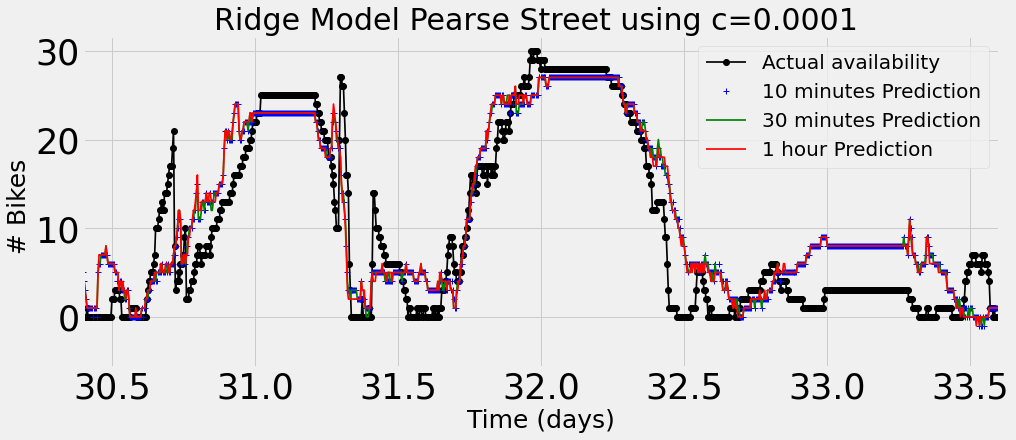

In [77]:
## now train the model using kfolds 
a = 0.0001
## just plot test data

tt,yy,XX = BuildModel(qVal[0],bikes,t)
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)
MSE =[]; meanE=[];stdE=[]
cv = TimeSeriesSplit(n_splits=5)
for train,test in cv.split(XX):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX[train],yy[train])
        
print(model.intercept_,model.coef_)
yPred=model.predict(XX)     
yPred=np.rint(yPred)
mse = mean_squared_error(yPred,yy)

tt1,yy1,XX1 = BuildModel(qVal[1],bikes,t)
train, test = train_test_split(np.arange(0,yy1.size),test_size=0.2,shuffle=False)
MSE =[]; meanE=[];stdE=[]
cv = TimeSeriesSplit(n_splits=5)
for train,test in cv.split(XX1):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX1[train],yy1[train])
       
print(model.intercept_,model.coef_)
yPred1=model.predict(XX1)     
yPred1	=np.rint(yPred1)
mse1 = mean_squared_error(yPred1,yy1)


tt2,yy2,XX2 = BuildModel(qVal[2],bikes,t)
train, test = train_test_split(np.arange(0,yy2.size),test_size=0.2,shuffle=False)
MSE =[]; meanE=[];stdE=[]
cv = TimeSeriesSplit(n_splits=5)
for train,test in cv.split(XX2):
        model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX2[train],yy2[train])
        
        
print(model.intercept_,model.coef_)
yPred2=model.predict(XX2)     
yp2 =np.rint(yPred2)
MSE2=mean_squared_error(yp2,yy2)


print("The mse for y=2 ,6,12 respectively is :",math.sqrt(mse),math.sqrt(mse1),math.sqrt(MSE2))

plt.plot(time,bikes,'-o',color='black')
plt.plot(tt,yPred,"+",color='blue')
plt.plot(tt1,yPred1,color='green')
plt.plot(tt2,yp2,color='red')
plt.title("Ridge Model Pearse Street using c=0.0001 ",size=30)
plt.legend(["Actual availability","10 minutes Prediction","30 minutes Prediction","1 hour Prediction"],loc='upper right',fontsize=20)
plt.xlim((4*7+4,4*8))
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.rcParams['figure.figsize']=[14,6]
plt.rc('xtick',labelsize=35)
plt.rc('ytick',labelsize=35)

In [149]:
## look at different trends 
def testPredictions(q,dd,lag,t,y):
    ## Replace this part for  other traing and 
    stride = 1 
    XX = y[0:y.size-q-lag*dd:stride]
    MSE =[]
    for i in range(1,lag):
        X = y[i*dd:y.size-q-(lag-i)*dd:stride]
        XX = np.column_stack((XX,X))
    yy = y[lag*dd+q::stride]
    tt=t[lag*dd+q::stride]
    ytrue = y[lag*dd+q::stride]

    train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
    model = Ridge(fit_intercept=False).fit(XX[train],yy[train])
    print(model.intercept_,model.coef_)

    yPred = model.predict(XX[test])
    MSE.append(mean_squared_error(yPred,yy[test]))
    print("Q :",q, "mse:" ,np.array(MSE).mean()  )